# Physics 494/594
## Exploring Model Complexity

In [2]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s.set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Last Time

### [Notebook Link: 09_Feature_Maps.ipynb](./09_Feature_Maps.ipynb)

-  Learn how linear regression can be used to fit data to non-linear functions using feature maps.

## Today

- Understanding model complexity and the bias-variance tradeoff
- Introduction to Regularization

### Polynomial Fitting

We used feature maps to implement a model consisting of a 3rd order polynomial:

\begin{align}
F_3(\vec{w},x) &= \vec{\varphi}(x) \cdot \vec{w}  \\
&= w_0 + w_1 x + w_2 x^2 + w_3 x^3
\end{align}

where \begin{equation}
\vec{w} = \left( \begin{array}{c}
w_0 \\
w_1 \\
w_2 \\
w_{3}
\end{array}
\right)
\end{equation}

and

\begin{equation}
\vec{\varphi}(x) = \left(
x^0, 
x^1,
x^2,
x^3
\right)\, .
\end{equation}

This was implemented as a new non-linear processing layer in our network.

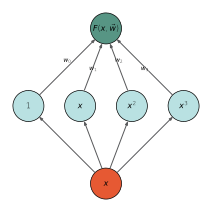

In [3]:
N = [1,4,1]
labels = [[r'$x$'],['1','$x$','$x^2$','$x^3$'],[r'$F(x,\vec{w})$']]
ml4s.draw_network(N,node_labels=labels, weights=[['' for i in range(N[1])],[f'$w_{i}$' for i in range(N[1])]], biases=[])

We loaded data from disk that we wanted to fit to the model:


<!--
x = np.linspace(0,1,10)
header = f"{'x':>13s}\t{'y':>15s}"
data_out = np.column_stack([x,np.sin(2*np.pi*x)+np.random.normal(loc=0,scale=0.15,size=x.size)])
np.savetxt('../data/poly_regression.dat', data_out,fmt='% 15.8e', header=header, delimiter='\t')
-->

Text(0, 0.5, 'y')

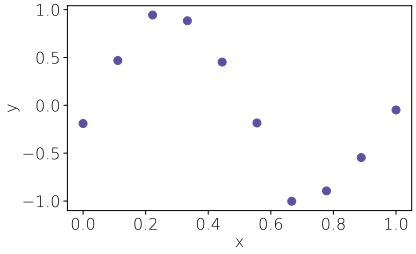

In [4]:
x,y = np.loadtxt('../data/poly_regression.dat',unpack=True)
plt.plot(x,y, 'o')
plt.xlabel('x')
plt.ylabel('y')

## Exploring Model Complexity

Last time we guessed the order of the polynomial for regression.  We can systematically explore the fit as a function of the order of the polynomial.

Text(0, 0.5, 'y')

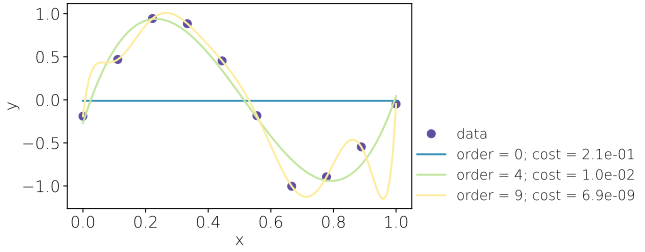

In [5]:
# the data
plt.plot(x,y, 'o', label='data', color=colors[0])

# the polynomial fits
W_opt = []
C_opt = []
x_fit = np.linspace(np.min(x),np.max(x),100)

poly_order = [0,4,9]

for n,cpoly_order in enumerate(poly_order):
    Φ = np.zeros([len(x),cpoly_order+1])
    for j in range(Φ.shape[1]):
        Φ[:,j] = x**j
        
    W_opt.append(np.linalg.inv(Φ.T @ Φ) @ Φ.T @ y)
    C_opt.append(0.5*np.average((Φ @ W_opt[n]-y)**2))
    
    Φ_fit = np.zeros([len(x_fit),cpoly_order+1])
    for j in range(Φ.shape[1]):
        Φ_fit[:,j] = x_fit**j

    plt.plot(x_fit,np.dot(Φ_fit,W_opt[n]),'-', color=colors[2*n+1], label=f'order = {poly_order[n]}; cost = {C_opt[n]:.1e}' )
        
plt.legend(loc=(1,0.0))
plt.xlabel('x')
plt.ylabel('y')

In this example we can observe two extremes:

**Underfitting:** Model is too simple – does not fit the data.

**Overfitting:** Model is too complex – fits perfectly but does not generalize.

We can explore this behavior systematically by employing knowledge from **Statistical Learning Theory** (see [Online Course](https://work.caltech.edu/telecourse) and associated textbook by Yaser Abu-Mostafa).

Let us consider our previous example (noisy $\sin(2\pi x)$) but with much more data ($N = 1000$):

\begin{equation}
\mathcal{D} = \{(x^{(n)},y^{(n)})\}_{n=1}^{1000}
\end{equation}


The **first step** is to randomly divide our data set $\mathcal{D}$ into two mutually exclusive groups $\mathcal{D}_{\rm train}$ and $\mathcal{D}_{\rm test}$.  Can do this with built-in `numpy` functions.  No hard-and-fast rule for the relative sizes (we are encountering one of our first *hyperparameters*), 80% is a good place to start.

In [6]:
x,y = np.loadtxt('../data/poly_regression_long.dat',unpack=True)

N_train = int(0.8*x.size)
indices = np.random.permutation(x.shape[0])
training_idx, test_idx = indices[:N_train], indices[N_train:]
x_train,x_test = x[training_idx],x[test_idx]
y_train,y_test = y[training_idx],y[test_idx]

But it is often simpler to use pre-canned versions from machine-learning libraries

In [7]:
x,y = np.loadtxt('../data/poly_regression_long.dat',unpack=True)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

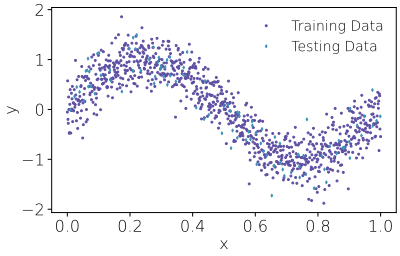

In [8]:
plt.plot(x_train,y_train, 'o', ms=2, label='Training Data')
plt.plot(x_test,y_test, 'd', ms=2, label='Testing Data')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

We then minimize the cost function using **only** data in the training set.  This gives us two different measurements of error:

#### In-Sample (training) Error
\begin{equation}
E_{\rm in} = \mathcal{C}\left(\vec{y}_{\rm train},F(\vec{x}_{\rm train}, \vec{w}^\ast)\right)
\end{equation}

#### Out-of-sample (testing) Error
\begin{equation}
E_{\rm out} = \mathcal{C}\left(\vec{y}_{\rm test},F(\vec{x}_{\rm test}, \vec{w}^\ast)\right)
\end{equation}

It is **almost always the case** that out-of-sample error is greater than in-sample error.

\begin{equation}
E_{\rm out} \ge E_{\rm in}.
\end{equation}

Splitting the data into mutually exclusive training and test sets provides an unbiased estimate for the predictive performance of the model — this is known as cross-validation in the ML and statistics literature.

In [97]:
W_opt = []
E_in,E_out = [],[]

poly_order = np.arange(16)

for n,cpoly_order in enumerate(poly_order):
    
    # training
    Φ = np.zeros([len(x_train),cpoly_order+1])
    for j in range(Φ.shape[1]):
        Φ[:,j] = x_train**j
        
    W_opt.append(np.linalg.inv(Φ.T @ Φ) @ Φ.T @ y_train)
    
    # in-sample (training) error
    E_in.append(0.5*np.average((Φ @ W_opt[n] - y_train)**2))
    
    # out-of-sample (testing) error
    Φ = np.zeros([len(x_test),cpoly_order+1])
    for j in range(Φ.shape[1]):
        Φ[:,j] = x_test**j
    E_out.append(0.5*np.average((Φ @ W_opt[n] - y_test)**2))
len(W_opt)

16

### Plot the Training and Testing Errors as a function of Model Complexity

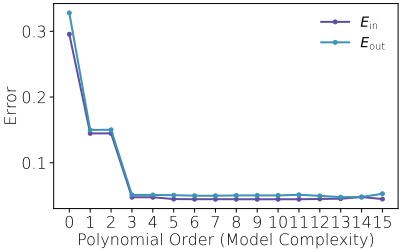

In [10]:
plt.plot(poly_order,E_in, marker='o', ms=4, label=r'$E_{\rm in}$')
plt.plot(poly_order,E_out, marker='o',ms=4, label=r'$E_{\rm out}$')

plt.xlabel('Polynomial Order (Model Complexity)')
plt.ylabel('Error')
plt.xticks(np.arange(0,np.max(poly_order)+1))
plt.legend()

## Regularized Least Squares

When we enter a regime of **overfitting** one consistent observation is that the fitting parameters tend to grow very large.

Text(0.5, 0, 'Power Index $j$')

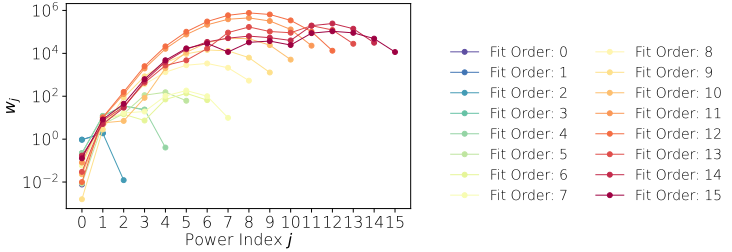

In [11]:
colors = ml4s.get_linear_colors('Spectral_r',len(poly_order))
for i,cW in enumerate(W_opt):
    plt.plot(np.abs(cW), '-o', ms=5, lw=1, color=colors[i], label=f'Fit Order: {i}')
plt.yscale('log')
plt.xticks(np.arange(0,np.max(poly_order)+1))
plt.ylabel(r'$w_j$')
plt.legend(ncol=2, loc=(1.1,0))
plt.xlabel(r'Power Index $j$')

A simple way to address this is just to punish large values of the weights in a modified cost function:

\begin{equation}
C_{\rm ridge}(\vec{w}) = \frac{1}{2}|| \vec{F}(\vec{w})-\vec{y}||^2 + \frac{\lambda}{2} ||\vec{w}||^2
\end{equation}

where $\lambda$ is a *regularization constant*.  This is another hyperparameters that we need to choose by investigation.  Different powers of the regression term can act differently ($||\vec{w}||$ is called *lasso* regression in the statistics literature).  For the choice above, our equation for the optimal parameters above is modified to:

\begin{equation}
\vec{w}^\ast = \left(\lambda \mathbb{1} + \mathbf{\Phi}^{\sf T} \mathbf{\Phi}\right)^{-1} \mathbf{\Phi}^{\sf T} \vec{y}
\end{equation}

where $\mathbb{1}$ is the $M\times M$ identity matrix.  Note the fact that the regularizer now prevents divergences if $\mathbf{\Phi}^{\sf T} \mathbf{\Phi}$ becomes singular.  We can easily modify our code above to use this regularizer.

<div class="span alert alert-success">
<h2>Programming Exercise: Ridge Regression </h2>

Adapt our analysis above to use use ridge regression.  Play around with different values of $\lambda$ to observe their effects.
</div>

In [186]:
W_opt2 = []
E_in2,E_out2 = [],[]

poly_order = np.arange(16)
λlist = [0,1,2,3,4,100] #list of λ to test

for i in range(len(λlist)):
    for n,cpoly_order in enumerate(poly_order):
    
        # training
        Φ = np.zeros([len(x_train),cpoly_order+1])
        for j in range(Φ.shape[1]):
            Φ[:,j] = x_train**j
            
        M = Φ.T @ Φ
        Mλ = λlist[i]*np.identity(n+1) + M
        
        W_opt2.append(np.linalg.inv(Mλ) @ Φ.T @ y_train)
    
        # in-sample (training) error
        E_in2.append(0.5*np.average((Φ @ W_opt2[n] - y_train)**2) + 0.5*λlist[i]*np.average(W_opt2[n])**2)
    
        # out-of-sample (testing) error
        Φ = np.zeros([len(x_test),cpoly_order+1])
        for j in range(Φ.shape[1]):
            Φ[:,j] = x_test**j
        E_out2.append(0.5*np.average((Φ @ W_opt2[n] - y_test)**2 + 0.5*λlist[i]*np.average(W_opt2[n])**2))

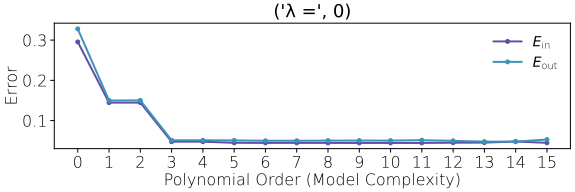

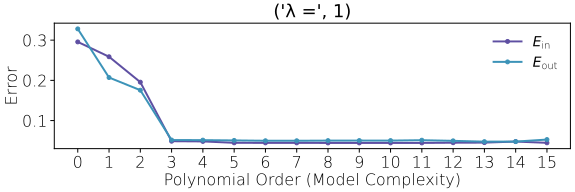

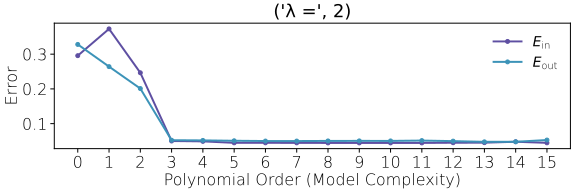

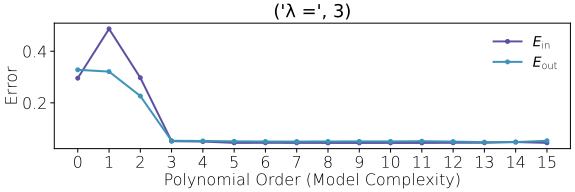

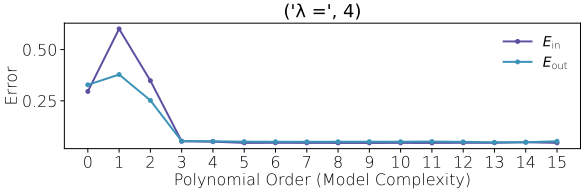

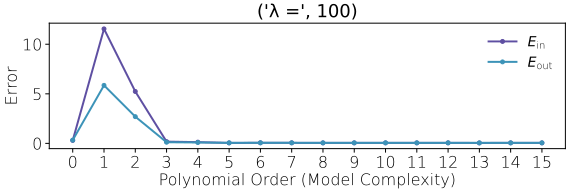

In [187]:
for i in range(len(λlist)):
    #16 = len(poly_order)
    poly_order = np.arange(16)
    plt.figure(figsize=(9,5))
    plt.subplot(2,1,2)
    plt.plot(poly_order,E_in2[i*(16):(i+1)*16], marker='o', ms=4, label=r'$E_{\rm in}$')
    plt.plot(poly_order,E_out2[i*(16):(i+1)*16], marker='o',ms=4, label=r'$E_{\rm out}$')

    plt.xlabel('Polynomial Order (Model Complexity)')
    plt.ylabel('Error')
    plt.title(('λ =', λlist[i]))
    plt.xticks(np.arange(0,np.max(poly_order)+1))
    plt.legend()

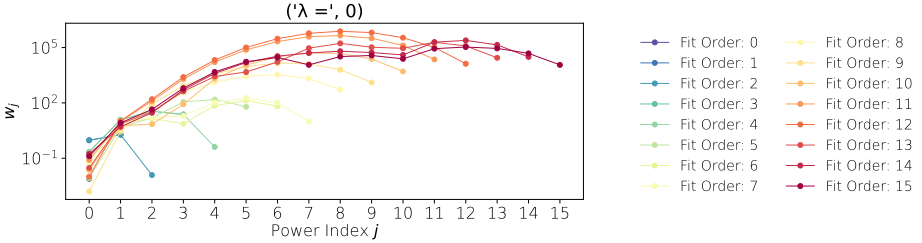

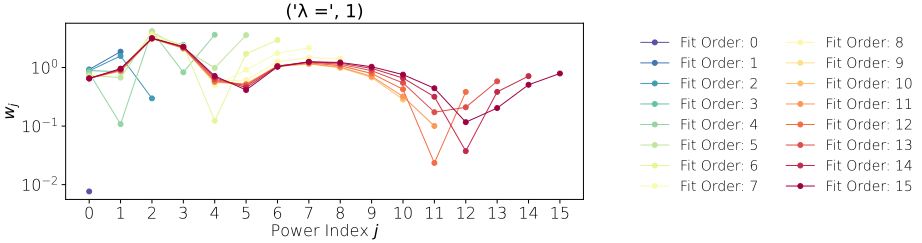

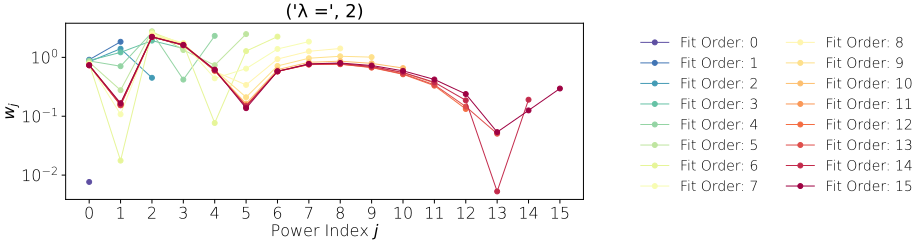

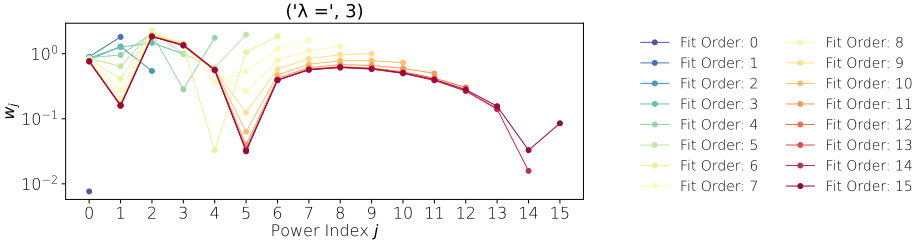

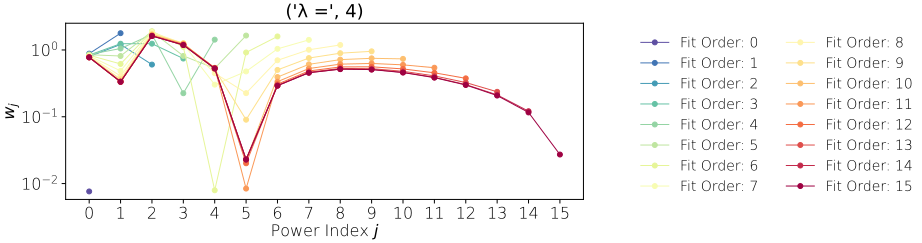

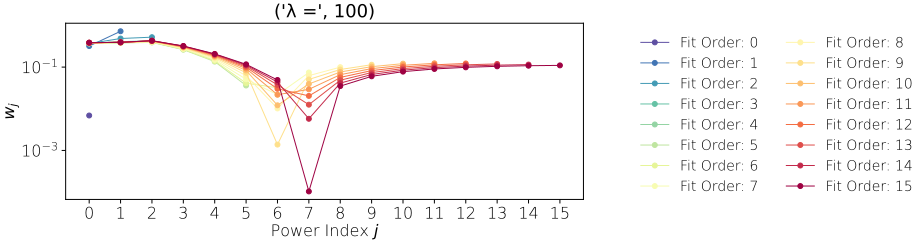

In [188]:
for j in range(len(λlist)):
    poly_order = np.arange(16)
    plt.figure(figsize=(9,7))
    plt.subplot(2,1,2)
    colors = ml4s.get_linear_colors('Spectral_r',len(poly_order))
    for i,cW in enumerate(W_opt2[j*(16):(j+1)*16]):
        plt.plot(np.abs(cW), '-o', ms=5, lw=1, color=colors[i], label=f'Fit Order: {i}')
    plt.yscale('log')
    plt.xticks(np.arange(0,np.max(poly_order)+1))
    plt.ylabel(r'$w_j$')
    plt.title(('λ =', λlist[j]))
    plt.legend(ncol=2, loc=(1.1,0))
    plt.xlabel(r'Power Index $j$')

We observe that larger values of λ tend to lower the magnitude of the weights. More importantly, the range over which most of the weights vary seems to be smaller. This is very observable in the λ = 100 graph, where all the weights are fairly close except for the fit order 7. 